# Data Structure


In [ ]:
# DATASET/
#     HEALTHY PLANT/
#         APPLE/
#             apple01.jpg
#             apple02.jpg
#             ...
#         BLUBERRY/
#             bluberry01.jpg
#             bluberry02.jpg
#             ...
#         ...
#     JENIS TANAH/
#         ALUVIAL/
#             aluvial_1.jpg
#             aluvial_2.jpg
#             ...
#         CHERNOZEM/
#             chernozem_1.jpg
#             chernozem_2.jpg
#             ...
#         ...
#     PENYAKIT/
#         BACTERIAL_SPOT/
#             bacterial_spot01.jpg
#             bacterial_spot02.jpg
#             ...
#         BLACK_MEASLES/
#             black_measles01.jpg
#             black_measles02.jpg
#             ...
#         ...


# Load data

In [ ]:
!git clone https://github.com/Flora-Vista-Bangkit-Capstone/ML-AI.git

Cloning into 'ML-AI'...
remote: Enumerating objects: 10102, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 10102 (delta 25), reused 18 (delta 3), pack-reused 10035
Receiving objects: 100% (10102/10102), 911.14 MiB | 14.81 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Updating files: 100% (6551/6551), done.


In [ ]:
!pip install tensorflow==2.15.0

import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
# import tensorflow as tf
import matplotlib
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Split data healthy plant

In [ ]:
def create_train_test_val_dirs(root_dir, categories):
    for category in categories:
        train_dir = os.path.join(root_dir, 'train', category)
        test_dir = os.path.join(root_dir, 'test', category)
        val_dir = os.path.join(root_dir, 'validation', category)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        print(f"Created directories: {train_dir}, {test_dir}, {val_dir}")


In [ ]:
def split_data(SOURCE, TRAINING, TEST, VALIDATION, train_split, test_split):
    all_files = os.listdir(SOURCE)
    np.random.shuffle(all_files)
    train_size = int(len(all_files) * train_split)
    test_size = int(len(all_files) * test_split)
    val_size = len(all_files) - train_size - test_size

    train_files = all_files[:train_size]
    test_files = all_files[train_size:train_size + test_size]
    val_files = all_files[train_size + test_size:]

    print(f"Splitting {len(all_files)} files into {len(train_files)} train, {len(test_files)} test and {len(val_files)} validation")

    for file in train_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(TRAINING, file))
        print(f"Copied {file} to {TRAINING}")

    for file in test_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(TEST, file))
        print(f"Copied {file} to {TEST}")

    for file in val_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(VALIDATION, file))
        print(f"Copied {file} to {VALIDATION}")


In [ ]:
root_dir = '/content/ML-AI/DATASET/HEALTHY PLANT'
categories = ['APPLE', 'BLUEBERRY', 'CHERRY', 'CORN', 'GRAPE', 'PEACH', 'PEPPER', 'POTATO', 'RASPBERRY', 'SOYBEAN', 'STRAWBERRY', 'TOMATO']

# Create train, test and validation directories
create_train_test_val_dirs(root_dir, categories)

# Split data
train_split = 0.7  # 70% training
test_split = 0.2   # 20% testing

for category in categories:
    source_dir = os.path.join(root_dir, category)
    training_dir = os.path.join(root_dir, 'train', category)
    test_dir = os.path.join(root_dir, 'test', category)
    validation_dir = os.path.join(root_dir, 'validation', category)

    if not os.path.exists(source_dir):
        print(f"Source directory does not exist: {source_dir}")
        continue

    split_data(source_dir, training_dir, test_dir, validation_dir, train_split, test_split)


Created directories: /content/ML-AI/DATASET/HEALTHY PLANT/train/APPLE, /content/ML-AI/DATASET/HEALTHY PLANT/test/APPLE, /content/ML-AI/DATASET/HEALTHY PLANT/validation/APPLE
Created directories: /content/ML-AI/DATASET/HEALTHY PLANT/train/BLUEBERRY, /content/ML-AI/DATASET/HEALTHY PLANT/test/BLUEBERRY, /content/ML-AI/DATASET/HEALTHY PLANT/validation/BLUEBERRY
Created directories: /content/ML-AI/DATASET/HEALTHY PLANT/train/CHERRY, /content/ML-AI/DATASET/HEALTHY PLANT/test/CHERRY, /content/ML-AI/DATASET/HEALTHY PLANT/validation/CHERRY
Created directories: /content/ML-AI/DATASET/HEALTHY PLANT/train/CORN, /content/ML-AI/DATASET/HEALTHY PLANT/test/CORN, /content/ML-AI/DATASET/HEALTHY PLANT/validation/CORN
Created directories: /content/ML-AI/DATASET/HEALTHY PLANT/train/GRAPE, /content/ML-AI/DATASET/HEALTHY PLANT/test/GRAPE, /content/ML-AI/DATASET/HEALTHY PLANT/validation/GRAPE
Created directories: /content/ML-AI/DATASET/HEALTHY PLANT/train/PEACH, /content/ML-AI/DATASET/HEALTHY PLANT/test/PEACH

# Data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path_healthy = '/content/ML-AI/DATASET/HEALTHY PLANT/train'
val_path_healthy = '/content/ML-AI/DATASET/HEALTHY PLANT/validation'
test_path_healthy = '/content/ML-AI/DATASET/HEALTHY PLANT/test'

train_datagen_healthy = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_healthy = train_datagen_healthy.flow_from_directory(
    train_path_healthy,
    target_size=(224, 224),  # Menentukan ukuran gambar yang diharapkan
    batch_size=32,
    class_mode='categorical'
)

validation_generator_healthy = val_test_datagen.flow_from_directory(
    val_path_healthy,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator_healthy = val_test_datagen.flow_from_directory(
    test_path_healthy,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Untuk evaluasi, pastikan tidak diacak
)

label_dict_healthy = train_generator_healthy.class_indices

label_dict = {}
label_dict.update(label_dict_healthy)

for label, idx in label_dict.items():
    print(f"index {idx}: {label}")

print(train_generator_healthy.class_indices)

labels_txt_healthy = '\n'.join(sorted(train_generator_healthy.class_indices.keys()))

with open('labels_healthy.txt', 'w') as f:
    f.write(labels_txt_healthy)


Found 1260 images belonging to 12 classes.
Found 180 images belonging to 12 classes.
Found 360 images belonging to 12 classes.
index 0: APPLE
index 1: BLUEBERRY
index 2: CHERRY
index 3: CORN
index 4: GRAPE
index 5: PEACH
index 6: PEPPER
index 7: POTATO
index 8: RASPBERRY
index 9: SOYBEAN
index 10: STRAWBERRY
index 11: TOMATO
{'APPLE': 0, 'BLUEBERRY': 1, 'CHERRY': 2, 'CORN': 3, 'GRAPE': 4, 'PEACH': 5, 'PEPPER': 6, 'POTATO': 7, 'RASPBERRY': 8, 'SOYBEAN': 9, 'STRAWBERRY': 10, 'TOMATO': 11}


#Train model

In [ ]:
from tensorflow.keras.applications import MobileNetV2

IMG_SHAPE = (224, 224, 3)

base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False
base_model.summary()

num_classes_healthy = len(label_dict_healthy)

model_healthy = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes_healthy, activation='softmax')  # Mengubah jumlah unit ke num_classes_healthy
])

model_healthy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_healthy.summary()

history = model_healthy.fit(
    train_generator_healthy,
    epochs=10,
    validation_data=validation_generator_healthy
)


9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [ ]:
loss, accuracy = model_healthy.evaluate(test_generator_healthy)
print(f'Test accuracy: {accuracy}')


12/12 [==============================] - 1s 122ms/step - loss: 0.1687 - accuracy: 0.9472
Test accuracy: 0.9472222328186035


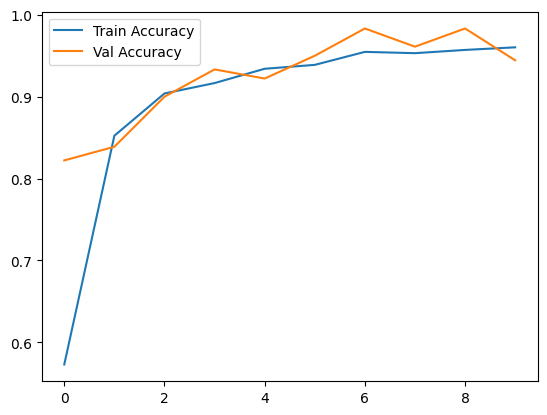

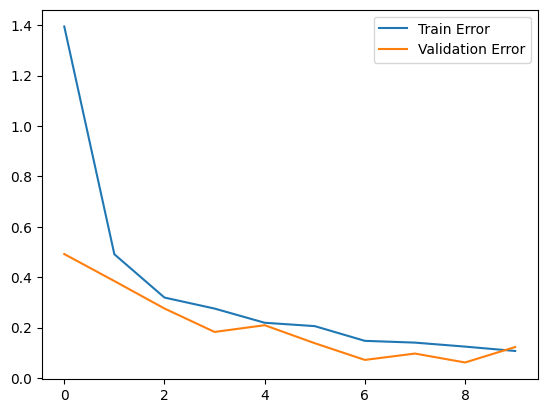

In [ ]:
plt.plot(history.history["accuracy"],label="Train Accuracy")
plt.plot(history.history["val_accuracy"],label="Val Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Train Error")
plt.plot(history.history["val_loss"],label="Validation Error")
plt.legend()
plt.show()

In [ ]:
# save model h5
model_healthy.save("model_plant_classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from keras.models import model_from_json

# Simpan arsitektur model ke dalam file JSON
model_json = model_healthy.to_json()
with open("model_plant_classification.json", "w") as json_file:
    json_file.write(model_json)

# Simpan bobot model ke dalam file biner
weights = model_healthy.get_weights()
with open("model_plant_classification.bin", "wb") as bin_file:
    for weight in weights:
        np.save(bin_file, weight)

print("Model dan bobot telah disimpan ke dalam file JSON dan BIN.")

Model dan bobot telah disimpan ke dalam file JSON dan BIN.


In [ ]:
# Load model keras
model = tf.keras.models.load_model('model_plant_classification.h5')

# Konversi model keras ke model TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke dalam file
with open('model_plant_classification.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model disimpan dalam format TFLite ke file model_plant_classification.tflite")

Model disimpan dalam format TFLite ke file model_plant_classification.tflite


In [ ]:
!pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 37.2 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow-lite-support


ERROR: Could not find a version that satisfies the requirement tensorflow-lite-support (from versions: none)
ERROR: No matching distribution found for tensorflow-lite-support


In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

# Tentukan path model TFLite
model_path = "model_plant_classification.tflite"
# Tentukan path model TFLite dengan metadata
model_with_metadata_path = "model_plant_classification_with_metadata.tflite"
# Tentukan path file label (jika ada)
label_file = "labels_healthy.txt"

# Buat metadata displayer untuk image classifier
writer = image_classifier.MetadataWriter.create_for_inference(
    writer_utils.load_file(model_path),
    input_norm_mean=[127.5],
    input_norm_std=[127.5],
    label_file_paths=[label_file]
)
# Serialize metadata dan tambahkan ke model
writer_utils.save_file(writer.populate(), model_with_metadata_path)

print("Model dengan metadata disimpan ke file model_plant_classification_with_metadata.tflite")

Model dengan metadata disimpan ke file model_plant_classification_with_metadata.tflite


#Prediksi gambar

1/1 [==============================] - 2s 2s/step
Predicted class: GRAPE
Confidence: 0.9893181


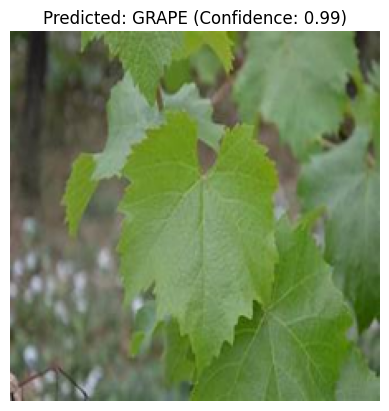

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi untuk mengunduh dan praproses gambar
def preprocess_image_from_url(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)  # Ubah ukuran gambar
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalisasi sesuai dengan MobileNetV2
    return img, img_array

# URL gambar yang ingin diuji
image_url = " https://tse4.mm.bing.net/th?id=OIP.6y0gSMQJZC3RMOrNNXkoUgHaE8&pid=Api&P=0&h=220 "

# Prakiraan dan praproses gambar
original_img, processed_img = preprocess_image_from_url(image_url, target_size=(224, 224))

# Lakukan prediksi
prediction = model_healthy.predict(processed_img)

# Interpretasi hasil prediksi
predicted_class_index = np.argmax(prediction)
confidence = prediction[0][predicted_class_index]

# Membuat kamus label
label_dict = train_generator_healthy.class_indices
index_to_label = {v: k for k, v in label_dict.items()}

# Print hasil
predicted_label = index_to_label[predicted_class_index]
print("Predicted class:", predicted_label)
print("Confidence:", confidence)

# Tampilkan gambar beserta prediksi
plt.imshow(original_img)
plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 67ms/step
Predicted class: CORN
Confidence: 0.99999034


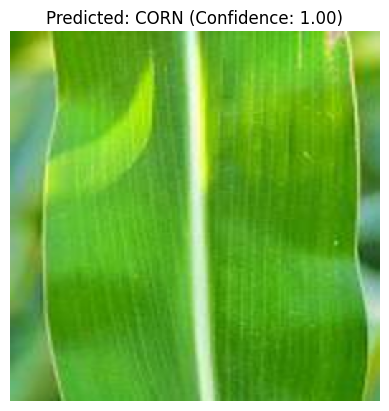

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi untuk mengunduh dan praproses gambar
def preprocess_image_from_url(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)  # Ubah ukuran gambar
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalisasi sesuai dengan MobileNetV2
    return img, img_array

# URL gambar yang ingin diuji
image_url = " https://tse3.mm.bing.net/th?id=OIP.t3w3EBzwnwu7G3f_7IlECQAAAA&pid=Api&P=0&h=220 "
# Prakiraan dan praproses gambar
original_img, processed_img = preprocess_image_from_url(image_url, target_size=(224, 224))

# Lakukan prediksi
prediction = model_healthy.predict(processed_img)

# Interpretasi hasil prediksi
predicted_class_index = np.argmax(prediction)
confidence = prediction[0][predicted_class_index]

# Membuat kamus label
label_dict = train_generator_healthy.class_indices
index_to_label = {v: k for k, v in label_dict.items()}

# Print hasil
predicted_label = index_to_label[predicted_class_index]
print("Predicted class:", predicted_label)
print("Confidence:", confidence)

# Tampilkan gambar beserta prediksi
plt.imshow(original_img)
plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 29ms/step
Predicted class: CHERRY
Confidence: 0.77508396


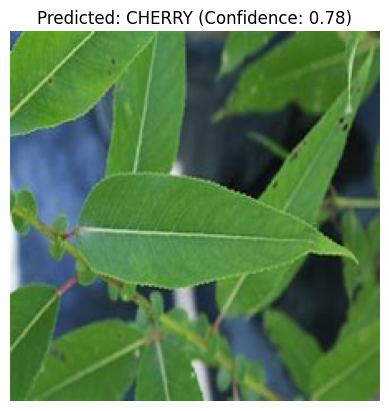

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi untuk mengunduh dan praproses gambar
def preprocess_image_from_url(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)  # Ubah ukuran gambar
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalisasi sesuai dengan MobileNetV2
    return img, img_array

# URL gambar yang ingin diuji
image_url = " https://tse4.mm.bing.net/th?id=OIP.OyD0bgNAL3MOGEJmOKUOBgHaE8&pid=Api&P=0&h=220"
# Prakiraan dan praproses gambar
original_img, processed_img = preprocess_image_from_url(image_url, target_size=(224, 224))

# Lakukan prediksi
prediction = model_healthy.predict(processed_img)

# Interpretasi hasil prediksi
predicted_class_index = np.argmax(prediction)
confidence = prediction[0][predicted_class_index]

# Membuat kamus label
label_dict = train_generator_healthy.class_indices
index_to_label = {v: k for k, v in label_dict.items()}

# Print hasil
predicted_label = index_to_label[predicted_class_index]
print("Predicted class:", predicted_label)
print("Confidence:", confidence)

# Tampilkan gambar beserta prediksi
plt.imshow(original_img)
plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()


#confusion matrix

In [ ]:
# Menghasilkan prediksi untuk data uji
y_pred = model_healthy.predict(test_generator_healthy)
# Mengambil kelas dengan probabilitas tertinggi
y_pred_classes = np.argmax(y_pred, axis=1)
# Mengambil label sebenarnya
y_true = test_generator_healthy.classes


12/12 [==============================] - 2s 62ms/step


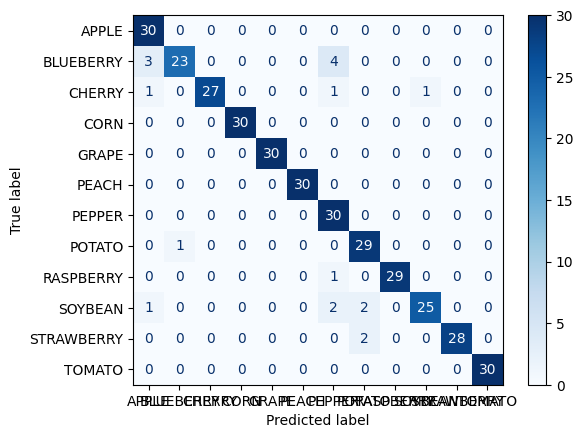

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator_healthy.class_indices.keys())
cmd.plot(cmap='Blues', values_format='d')
